In [46]:
#Pull in Data
import pandas as pd
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('Train_Table.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,id,bedrooms,bathrooms,sqft_living,log_lot,sqft_lot,floors,waterfront,condition,grade,zipcode,lat,long,yr_of_last_update,season_sold,below_ground_ratio,price_100k,long_lat,district,is_seattle
0,7504400290,5,2.50,3470,9.392912,12003,2.0,0.0,3,8,98074,47.6240,-122.048,1978,Spring,0.000000,5.990,"(-122.04799999999999, 47.623999999999995)",Lake Washington,0.0
1,6403500570,5,2.75,2990,8.911934,7420,2.0,0.0,3,8,98059,47.4944,-122.162,1996,Summer,0.000000,4.985,"(-122.162, 47.4944)",Renton,0.0
2,7934000145,4,2.75,2900,8.764053,6400,2.0,0.0,3,7,98136,47.5563,-122.393,1970,Winter,0.421569,4.500,"(-122.39299999999999, 47.5563)",Seattle,1.0
3,203100625,3,2.50,2620,9.979847,21587,2.0,0.0,3,7,98053,47.6384,-121.959,1992,Spring,0.000000,6.720,"(-121.959, 47.6384)",Snoqualmie Valley,0.0
4,2211700160,3,1.50,1770,9.753130,17208,1.0,0.0,3,8,98006,47.5659,-122.117,1959,Spring,0.525862,4.500,"(-122.117, 47.5659)",Issaquah,0.0


In [47]:
df.shape

(17094, 20)

## Check For Multicollinearity

In [53]:
def check_multicollinearity(df, independent_var_name, cutoff):
    copy_df = df.drop(independent_var_name, axis=1)
    # copy_df = reg_df

    # save absolute value of correlation matrix as a data frame
    # converts all values to absolute value
    # stacks the row:column pairs into a multindex
    # reset the index to set the multindex to seperate columns
    # sort values. 0 is the column automatically generated by the stacking

    pair_df=copy_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    # zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    pair_df['pairs'] = list(zip(pair_df.level_0, pair_df.level_1))

    # set index to pairs
    pair_df.set_index(['pairs'], inplace = True)

    #drop level columns
    pair_df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column
    pair_df.columns = ['correlation_coefficient']

    # drop duplicates. 
    pair_df.drop_duplicates(inplace=True)
    return pair_df[(pair_df.correlation_coefficient>cutoff) & (pair_df.correlation_coefficient <1)]

In [54]:
check_multicollinearity(reg_df, 'price_100k', 0.6)

,correlation_coefficient
pairs,
"(grade, sqft_living)",0.750909
"(bathrooms, sqft_living)",0.742246
"(grade, bathrooms)",0.650483


## District -> top_5_district

In [55]:
# https://backgroundchecks.org/top-school-districts-in-washington-2018.html
# Rankings based on student performance (math and reading test scores), dropout rates, school funding, and area poverty rates

top_5_str = 'Mercer Island|Lake Washington|Snoqualmie Valley|Bellevue|Issaquah'
reg_df.loc[reg_df['district'].str.contains(top_5_str),'top_5_district'] = 1
reg_df['top_5_district'].fillna(0, inplace=True)
reg_df.head()

,bedrooms,bathrooms,sqft_living,log_lot,floors,waterfront,condition,grade,yr_of_last_update,season_sold,below_ground_ratio,price_100k,district,is_seattle,top_5_district
0,5,2.50,3470,9.392912,2.0,0.0,3,8,1978,Spring,0.000000,5.990,Lake Washington,0.0,1.0
1,5,2.75,2990,8.911934,2.0,0.0,3,8,1996,Summer,0.000000,4.985,Renton,0.0,0.0
2,4,2.75,2900,8.764053,2.0,0.0,3,7,1970,Winter,0.421569,4.500,Seattle,1.0,0.0
3,3,2.50,2620,9.979847,2.0,0.0,3,7,1992,Spring,0.000000,6.720,Snoqualmie Valley,0.0,1.0
4,3,1.50,1770,9.753130,1.0,0.0,3,8,1959,Spring,0.525862,4.500,Issaquah,0.0,1.0


In [56]:
reg_df.drop(['district'], axis=1, inplace=True)

## Get Season Dummy Variables

In [57]:
#Dummy var for season_sold, with Summer as the reference variable
seasons = pd.get_dummies(reg_df['season_sold'], drop_first=True)
reg_df = pd.concat([reg_df, seasons], axis=1)
# reg_df.drop(['Summer'], axis=1, inplace=True)

In [58]:
reg_df = reg_df.drop(['season_sold'], axis=1)
reg_df.head()

,bedrooms,bathrooms,sqft_living,log_lot,floors,waterfront,condition,grade,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,Spring,Summer,Winter
0,5,2.50,3470,9.392912,2.0,0.0,3,8,1978,0.000000,5.990,0.0,1.0,1,0,0
1,5,2.75,2990,8.911934,2.0,0.0,3,8,1996,0.000000,4.985,0.0,0.0,0,1,0
2,4,2.75,2900,8.764053,2.0,0.0,3,7,1970,0.421569,4.500,1.0,0.0,0,0,1
3,3,2.50,2620,9.979847,2.0,0.0,3,7,1992,0.000000,6.720,0.0,1.0,1,0,0
4,3,1.50,1770,9.753130,1.0,0.0,3,8,1959,0.525862,4.500,0.0,1.0,1,0,0


## Regression 1

Treating bathrooms, grade, etc as continuous in this regression.

In [59]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

outcome = 'price_100k'
predictors = reg_df.drop('price_100k', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [60]:
model = ols(formula=formula, data=reg_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     2841.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:31:27   Log-Likelihood:                -31704.
No. Observations:               17094   AIC:                         6.344e+04
Df Residuals:                   17078   BIC:                         6.356e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.0568      1.279     19.587      0.000      22.549      27.564
bedrooms              -0.1872      0.017    -10.923      0.000      -0.221      -0.154
bathrooms              0.2461      0.028      8.645      0.000       0.190       0.302
sqft_living            0.0015   3.01e-05     49.794      0.000       0.001       0.002
log_lot                0.0596      0.018      3.373      0.001       0.025       0.094
floors                -0.1605      0.034     -4.675      0.000      -0.228      -0.093
waterfront             4.9186      0.171     28.745      0.000       4.583       5.254
condition              0.2966      0.020     14.637      0.000       0.257       0.336
grade                  0.9434      0.018     52.811      0.000       0.908       0.978
yr_of_last_update     -0.0165      0.001    -25.836      0.000      -0.018      -0.015
below_ground_ratio    -0.5178      0.051    -10.064      0.000      -0.619      -0.417
is_seattle             2.1254      0.037     57.961      0.000       2.054       2.197
top_5_district         1.8324      0.031     59.697      0.000       1.772       1.893
Spring                 0.2799      0.033      8.583      0.000       0.216       0.344
Summer                 0.0181      0.033      0.552      0.581      -0.046       0.083
Winter                 0.0766      0.038      2.036      0.042       0.003       0.150
==============================================================================
Omnibus:                     5666.973   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33728.893
Skew:                           1.467   Prob(JB):                         0.00
Kurtosis:                       9.225   Cond. No.                     3.16e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
# Drop non-significant variables
outcome = 'price_100k'
predictors = reg_df.drop(['price_100k', 'Summer'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=reg_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     3044.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:31:27   Log-Likelihood:                -31705.
No. Observations:               17094   AIC:                         6.344e+04
Df Residuals:                   17079   BIC:                         6.356e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.0553      1.279     19.586      0.000      22.548      27.563
bedrooms              -0.1872      0.017    -10.921      0.000      -0.221      -0.154
bathrooms              0.2460      0.028      8.642      0.000       0.190       0.302
sqft_living            0.0015   3.01e-05     49.792      0.000       0.001       0.002
log_lot                0.0597      0.018      3.378      0.001       0.025       0.094
floors                -0.1605      0.034     -4.675      0.000      -0.228      -0.093
waterfront             4.9174      0.171     28.741      0.000       4.582       5.253
condition              0.2968      0.020     14.650      0.000       0.257       0.337
grade                  0.9435      0.018     52.824      0.000       0.908       0.979
yr_of_last_update     -0.0165      0.001    -25.832      0.000      -0.018      -0.015
below_ground_ratio    -0.5177      0.051    -10.062      0.000      -0.618      -0.417
is_seattle             2.1255      0.037     57.963      0.000       2.054       2.197
top_5_district         1.8326      0.031     59.709      0.000       1.772       1.893
Spring                 0.2698      0.027      9.975      0.000       0.217       0.323
Winter                 0.0665      0.033      2.021      0.043       0.002       0.131
==============================================================================
Omnibus:                     5668.149   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33746.493
Skew:                           1.467   Prob(JB):                         0.00
Kurtosis:                       9.227   Cond. No.                     3.16e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Check Residuals!!**

In [62]:
# Check Homoskedasticity
def gq_test(data, model):
    
    #Graph heteroskedasticity
    pred_val = model.fittedvalues.copy()
#     true_val = data['price_100k'].values.copy()
    residual = model.resid
    
    fig, ax = plt.subplots()
    graph = ax.scatter(pred_val, residual)
    
    # Run Goldfeld Quandt test
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(model.resid, model.model.exog)
    return list(zip(name, test))


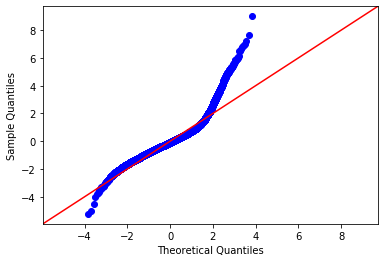

In [63]:
#Normality check for residuals with QQ plot
resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)

[('F statistic', 1.0475445683807323), ('p-value', 0.01597415265999172)]

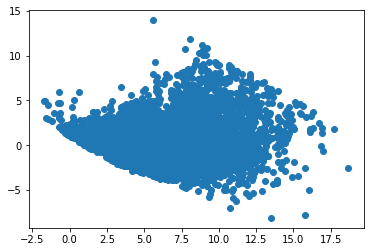

In [64]:
gq_test(reg_df, model)

## Regression 2 - New Dummy Variables

Creating Dummy Variables for Floors, Grade, Condition


In [65]:
#Floors
reg_df2 = reg_df
floors = pd.get_dummies(reg_df2['floors'], prefix='floors', drop_first=True)
reg_df2 = pd.concat([reg_df2, floors], axis=1)
reg_df2.drop('floors', axis=1, inplace=True)

#Rename floors so no decimal in column name
reg_df2.rename(columns={'floors_1.5':'floors_1h','floors_2.0':'floors_2','floors_2.5':'floors_2h','floors_3.0':'floors_3','floors_3.5':'floors_3h'}, inplace=True)
reg_df2.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,grade,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,Spring,Summer,Winter,floors_1h,floors_2,floors_2h,floors_3,floors_3h
0,5,2.50,3470,9.392912,0.0,3,8,1978,0.000000,5.990,0.0,1.0,1,0,0,0,1,0,0,0
1,5,2.75,2990,8.911934,0.0,3,8,1996,0.000000,4.985,0.0,0.0,0,1,0,0,1,0,0,0
2,4,2.75,2900,8.764053,0.0,3,7,1970,0.421569,4.500,1.0,0.0,0,0,1,0,1,0,0,0
3,3,2.50,2620,9.979847,0.0,3,7,1992,0.000000,6.720,0.0,1.0,1,0,0,0,1,0,0,0
4,3,1.50,1770,9.753130,0.0,3,8,1959,0.525862,4.500,0.0,1.0,1,0,0,0,0,0,0,0


In [66]:
#Grade - Data in master table ranges from 3-13
grade = pd.get_dummies(reg_df2['grade'], prefix='grade', drop_first=True)
reg_df2 = pd.concat([reg_df2, grade], axis=1)
reg_df2.drop('grade', axis=1, inplace=True)
reg_df2.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,5,2.50,3470,9.392912,0.0,3,1978,0.000000,5.990,0.0,...,0,0,0,0,1,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,3,1996,0.000000,4.985,0.0,...,0,0,0,0,1,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,3,1970,0.421569,4.500,1.0,...,0,0,0,1,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,3,1992,0.000000,6.720,0.0,...,0,0,0,1,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,3,1959,0.525862,4.500,0.0,...,0,0,0,0,1,0,0,0,0,0


In [67]:
#Condition 
condition = pd.get_dummies(reg_df2['condition'], prefix='cond', drop_first=True)
reg_df2 = pd.concat([reg_df2, condition], axis=1)
reg_df2.drop('condition', axis=1, inplace=True)
reg_df2.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,cond_2,cond_3,cond_4,cond_5
0,5,2.50,3470,9.392912,0.0,1978,0.000000,5.990,0.0,1.0,...,1,0,0,0,0,0,0,1,0,0
1,5,2.75,2990,8.911934,0.0,1996,0.000000,4.985,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
2,4,2.75,2900,8.764053,0.0,1970,0.421569,4.500,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,3,2.50,2620,9.979847,0.0,1992,0.000000,6.720,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,3,1.50,1770,9.753130,0.0,1959,0.525862,4.500,0.0,1.0,...,1,0,0,0,0,0,0,1,0,0


In [68]:
predictors.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'log_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_of_last_update',
       'below_ground_ratio', 'is_seattle', 'top_5_district', 'Spring',
       'Winter'],
      dtype='object')

In [69]:
outcome = 'price_100k'
predictors = reg_df2.drop('price_100k', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=reg_df2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1433.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:31:33   Log-Likelihood:                -31441.
No. Observations:               17094   AIC:                         6.295e+04
Df Residuals:                   17062   BIC:                         6.319e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.1604      2.044     13.289      0.000      23.154      31.166
bedrooms              -0.1211      0.017     -6.992      0.000      -0.155      -0.087
bathrooms              0.2793      0.028      9.859      0.000       0.224       0.335
sqft_living            0.0014    3.1e-05     43.849      0.000       0.001       0.001
log_lot                0.0482      0.017      2.754      0.006       0.014       0.082
waterfront             4.8166      0.169     28.543      0.000       4.486       5.147
yr_of_last_update     -0.0139      0.001    -20.671      0.000      -0.015      -0.013
below_ground_ratio    -0.3800      0.053     -7.231      0.000      -0.483      -0.277
is_seattle             2.1047      0.037     57.569      0.000       2.033       2.176
top_5_district         1.8094      0.030     59.695      0.000       1.750       1.869
Spring                 0.2767      0.032      8.607      0.000       0.214       0.340
Summer                 0.0262      0.032      0.810      0.418      -0.037       0.090
Winter                 0.0703      0.037      1.895      0.058      -0.002       0.143
floors_1h             -0.0031      0.047     -0.067      0.947      -0.095       0.089
floors_2              -0.2617      0.039     -6.637      0.000      -0.339      -0.184
floors_2h              0.2624      0.150      1.750      0.080      -0.031       0.556
floors_3              -0.0305      0.087     -0.352      0.725      -0.201       0.140
floors_3h             -0.1524      0.882     -0.173      0.863      -1.881       1.576
grade_4               -0.5704      1.565     -0.365      0.715      -3.637       2.497
grade_5               -0.6333      1.529     -0.414      0.679      -3.630       2.364
grade_6               -0.5888      1.526     -0.386      0.700      -3.579       2.401
grade_7                0.0190      1.526      0.012      0.990      -2.971       3.009
grade_8                0.8375      1.526      0.549      0.583      -2.154       3.829
grade_9                2.0868      1.527      1.367      0.172      -0.906       5.079
grade_10               3.3062      1.528      2.164      0.030       0.312       6.301
grade_11               4.6901      1.531      3.064      0.002       1.690       7.690
grade_12               7.0178      1.544      4.544      0.000       3.991      10.045
grade_13               9.2811      2.159      4.299      0.000       5.049      13.513
cond_2                -0.0801      0.346     -0.231      0.817      -0.759       0.599
cond_3                 0.2067      0.321      0.645      0.519      -0.422       0.835
cond_4                 0.4852      0.321      1.513      0.130      -0.143       1.114
cond_5                 0.8998      0.323      2.790      0.005       0.268       1.532
======================================

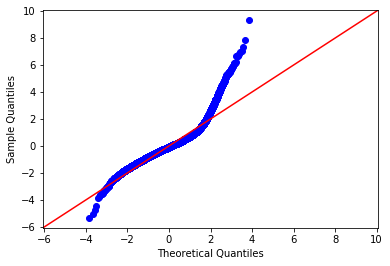

In [70]:
#Normality check for residuals with QQ plot
resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)

[('F statistic', 1.036604823912329), ('p-value', 0.04858643950891584)]

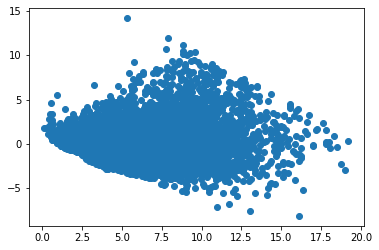

In [71]:
gq_test(reg_df2, model)

## Regression 3

Same as above but set dummy var reference variable as middle value

In [72]:
#Floors
reg_df3 = reg_df
floors = pd.get_dummies(reg_df3['floors'], prefix='floors')
reg_df3 = pd.concat([reg_df3, floors], axis=1)
reg_df3.drop('floors', axis=1, inplace=True)

#Drop floor 2 to make it ref var
reg_df3.drop('floors_2.0', axis=1, inplace=True)

#Rename floors so no decimal in column name
reg_df3.rename(columns={'floors_1.0':'floors_1', 'floors_1.5':'floors_1h','floors_2.0':'floors_2','floors_2.5':'floors_2h','floors_3.0':'floors_3','floors_3.5':'floors_3h'}, inplace=True)

reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,grade,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,Spring,Summer,Winter,floors_1,floors_1h,floors_2h,floors_3,floors_3h
0,5,2.50,3470,9.392912,0.0,3,8,1978,0.000000,5.990,0.0,1.0,1,0,0,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,3,8,1996,0.000000,4.985,0.0,0.0,0,1,0,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,3,7,1970,0.421569,4.500,1.0,0.0,0,0,1,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,3,7,1992,0.000000,6.720,0.0,1.0,1,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,3,8,1959,0.525862,4.500,0.0,1.0,1,0,0,1,0,0,0,0


In [73]:
#Grade - Data in master table ranges from 3-13
grade = pd.get_dummies(reg_df3['grade'], prefix='grade')
reg_df3 = pd.concat([reg_df3, grade], axis=1)

#Drop Grade 7 (average grade) to make ref var
reg_df3.drop('grade_7', axis=1, inplace=True)

reg_df3.drop('grade', axis=1, inplace=True)
reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,...,grade_3,grade_4,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,5,2.50,3470,9.392912,0.0,3,1978,0.000000,5.990,0.0,...,0,0,0,0,1,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,3,1996,0.000000,4.985,0.0,...,0,0,0,0,1,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,3,1970,0.421569,4.500,1.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,3,1992,0.000000,6.720,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,3,1959,0.525862,4.500,0.0,...,0,0,0,0,1,0,0,0,0,0


In [74]:
#Condition 
condition = pd.get_dummies(reg_df3['condition'], prefix='cond')
reg_df3 = pd.concat([reg_df3, condition], axis=1)

#Drop Condition 3 (average cond) to make ref var
reg_df3.drop('cond_3', axis=1, inplace=True)

reg_df3.drop('condition', axis=1, inplace=True)
reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,cond_1,cond_2,cond_4,cond_5
0,5,2.50,3470,9.392912,0.0,1978,0.000000,5.990,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,1996,0.000000,4.985,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,1970,0.421569,4.500,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,1992,0.000000,6.720,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,1959,0.525862,4.500,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0


In [75]:
outcome = 'price_100k'
predictors = reg_df3.drop('price_100k', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=reg_df3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1433.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:31:39   Log-Likelihood:                -31441.
No. Observations:               17094   AIC:                         6.295e+04
Df Residuals:                   17062   BIC:                         6.319e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.1244      1.362     19.916      0.000      24.455      29.794
bedrooms              -0.1211      0.017     -6.992      0.000      -0.155      -0.087
bathrooms              0.2793      0.028      9.859      0.000       0.224       0.335
sqft_living            0.0014    3.1e-05     43.849      0.000       0.001       0.001
log_lot                0.0482      0.017      2.754      0.006       0.014       0.082
waterfront             4.8166      0.169     28.543      0.000       4.486       5.147
yr_of_last_update     -0.0139      0.001    -20.671      0.000      -0.015      -0.013
below_ground_ratio    -0.3800      0.053     -7.231      0.000      -0.483      -0.277
is_seattle             2.1047      0.037     57.569      0.000       2.033       2.176
top_5_district         1.8094      0.030     59.695      0.000       1.750       1.869
Spring                 0.2767      0.032      8.607      0.000       0.214       0.340
Summer                 0.0262      0.032      0.810      0.418      -0.037       0.090
Winter                 0.0703      0.037      1.895      0.058      -0.002       0.143
floors_1               0.2617      0.039      6.637      0.000       0.184       0.339
floors_1h              0.2586      0.054      4.822      0.000       0.153       0.364
floors_2h              0.5242      0.147      3.575      0.000       0.237       0.812
floors_3               0.2312      0.078      2.966      0.003       0.078       0.384
floors_3h              0.1093      0.881      0.124      0.901      -1.617       1.836
grade_3               -0.0190      1.526     -0.012      0.990      -3.009       2.971
grade_4               -0.5894      0.352     -1.673      0.094      -1.280       0.101
grade_5               -0.6524      0.115     -5.693      0.000      -0.877      -0.428
grade_6               -0.6079      0.045    -13.593      0.000      -0.696      -0.520
grade_8                0.8185      0.032     25.328      0.000       0.755       0.882
grade_9                2.0677      0.049     41.935      0.000       1.971       2.164
grade_10               3.2872      0.071     46.314      0.000       3.148       3.426
grade_11               4.6711      0.117     40.093      0.000       4.443       4.899
grade_12               6.9987      0.235     29.725      0.000       6.537       7.460
grade_13               9.2620      1.527      6.067      0.000       6.270      12.254
cond_1                -0.2067      0.321     -0.645      0.519      -0.835       0.422
cond_2                -0.2868      0.138     -2.084      0.037      -0.557      -0.017
cond_4                 0.2784      0.030      9.397      0.000       0.220       0.337
cond_5                 0.6931      0.048     14.566      0.000       0.600       0.786
======================================

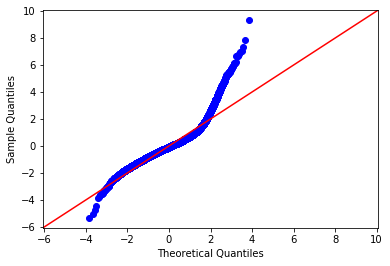

In [76]:
#Normality check for residuals with QQ plot
resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)

[('F statistic', 1.0366048239123289), ('p-value', 0.04858643950896008)]

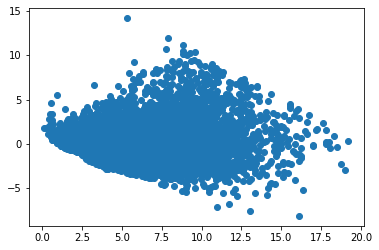

In [77]:
gq_test(reg_df3, model)

## Make Predictions

Following steps in "Polynomial Regression" lecture.  Redoing model using OLS()

In [78]:
y = reg_df3['price_100k']
independent_variables = list(predictors.columns)
X = reg_df3[independent_variables]
display(X.head(3), y.head(3))

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,yr_of_last_update,below_ground_ratio,is_seattle,top_5_district,Spring,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,cond_1,cond_2,cond_4,cond_5
0,5,2.50,3470,9.392912,0.0,1978,0.000000,0.0,1.0,1,...,1,0,0,0,0,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,1996,0.000000,0.0,0.0,0,...,1,0,0,0,0,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,1970,0.421569,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


0    5.990
1    4.985
2    4.500
Name: price_100k, dtype: float64

In [79]:
import statsmodels.api as sm

Xconst = sm.add_constant(X)

model = sm.OLS(y, Xconst, hasconst= True)

fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1433.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:31:44   Log-Likelihood:                -31441.
No. Observations:               17094   AIC:                         6.295e+04
Df Residuals:                   17062   BIC:                         6.319e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 27.1244      1.362     19.916      0.000      24.455      29.794
bedrooms              -0.1211      0.017     -6.992      0.000      -0.155      -0.087
bathrooms              0.2793      0.028      9.859      0.000       0.224       0.335
sqft_living            0.0014    3.1e-05     43.849      0.000       0.001       0.001
log_lot                0.0482      0.017      2.754      0.006       0.014       0.082
waterfront             4.8166      0.169     28.543      0.000       4.486       5.147
yr_of_last_update     -0.0139      0.001    -20.671      0.000      -0.015      -0.013
below_ground_ratio    -0.3800      0.053     -7.231      0.000      -0.483      -0.277
is_seattle             2.1047      0.037     57.569      0.000       2.033       2.176
top_5_district         1.8094      0.030     59.695      0.000       1.750       1.869
Spring                 0.2767      0.032      8.607      0.000       0.214       0.340
Summer                 0.0262      0.032      0.810      0.418      -0.037       0.090
Winter                 0.0703      0.037      1.895      0.058      -0.002       0.143
floors_1               0.2617      0.039      6.637      0.000       0.184       0.339
floors_1h              0.2586      0.054      4.822      0.000       0.153       0.364
floors_2h              0.5242      0.147      3.575      0.000       0.237       0.812
floors_3               0.2312      0.078      2.966      0.003       0.078       0.384
floors_3h              0.1093      0.881      0.124      0.901      -1.617       1.836
grade_3               -0.0190      1.526     -0.012      0.990      -3.009       2.971
grade_4               -0.5894      0.352     -1.673      0.094      -1.280       0.101
grade_5               -0.6524      0.115     -5.693      0.000      -0.877      -0.428
grade_6               -0.6079      0.045    -13.593      0.000      -0.696      -0.520
grade_8                0.8185      0.032     25.328      0.000       0.755       0.882
grade_9                2.0677      0.049     41.935      0.000       1.971       2.164
grade_10               3.2872      0.071     46.314      0.000       3.148       3.426
grade_11               4.6711      0.117     40.093      0.000       4.443       4.899
grade_12               6.9987      0.235     29.725      0.000       6.537       7.460
grade_13               9.2620      1.527      6.067      0.000       6.270      12.254
cond_1                -0.2067      0.321     -0.645      0.519      -0.835       0.422
cond_2                -0.2868      0.138     -2.084      0.037      -0.557      -0.017
cond_4                 0.2784      0.030      9.397      0.000       0.220       0.337
cond_5                 0.6931      0.048     14.566      0.000       0.600       0.786
======================================

In [80]:
#Find predictions
y_predict = fitted_model.predict(Xconst)

In [83]:
array_columns = independent_variables
array_columns.insert(0, 1)

[1,
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'log_lot',
 'waterfront',
 'yr_of_last_update',
 'below_ground_ratio',
 'is_seattle',
 'top_5_district',
 'Spring',
 'Summer',
 'Winter',
 'floors_1',
 'floors_1h',
 'floors_2h',
 'floors_3',
 'floors_3h',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'cond_1',
 'cond_2',
 'cond_4',
 'cond_5']

In [86]:
#Function to find index based on column name
def find_index(col_name, array_2d):
    x = 0
    for i in array_2d[0]:
        if i == col_name:
            return x
        else:
            x += 1

## Better User Input Function

In [42]:
def get_home_stats(df, col_names, fit_model, seattle=0, top_dist=0, spring=0):
    #Known variables given as inputs
    
    # Insignificant - Summer, Winter, floors_3h, grade_3, grade_4, cond_1
    
    empty_values = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    prediction_values = np.array([col_names, empty_values])
    

    
    #Floors
    floor_num = input("Number of floors ('1' for one floor, '1h' for 1.5 floors): ")
    floor_str = 'floors_' + str(floor_num)
    prediction_values[1][find_index(floor_str, prediction_values)] = 1
    
    #Bedrooms
    bed_num = input("Number of bedrooms (whole number): ")
    prediction_values[1][find_index('bedrooms', prediction_values)] = bed_num
    
    #Bathrooms
    bath_num = input("Number of bathrooms: ")
    prediction_values[1][find_index('bathrooms', prediction_values)] = bath_num
    
    #Waterfront
    wf = input("Is your house on the waterfront? (1 for yes, 0 for no): ")
    prediction_values[1][find_index('waterfront', prediction_values)] = wf
    
    #Square feet
    sqft = input("Total square feet: ")
    prediction_values[1][find_index('sqft_living', prediction_values)] = sqft
    
    #Grade
    grade_num = input("House grade(whole number 3-13): ")
    grade_str = 'grade_' + str(grade_num)
    prediction_values[1][find_index(grade_str, prediction_values)] = 1
    
    #Condition
    cond_num = input("House condition (whole number 1-5): ")
    cond_str = 'cond_' + str(cond_num)
    prediction_values[1][find_index(cond_str, prediction_values)] = 1
    
    
    #Set values for vars known from location/date
    prediction_values[1][find_index('is_seattle', prediction_values)] = seattle
    prediction_values[1][find_index('top_5_district', prediction_values)] = top_dist
    prediction_values[1][find_index('Spring', prediction_values)] = spring
    
    # Set values for unknown variables as median - log_lot, below_ground_ratio, yr_of_last_update
    prediction_values[1][find_index('log_lot', prediction_values)] = df['log_lot'].median()
    prediction_values[1][find_index('below_ground_ratio', prediction_values)] = df['below_ground_ratio'].median()
    prediction_values[1][find_index('yr_of_last_update', prediction_values)] = df['yr_of_last_update'].median()
    
    
    #Get values only in array
    prediction_input = prediction_values[1].astype(float)
    
    #Calculate intervals
    intervals = fit_model.get_prediction(prediction_input)
    bounds = intervals.summary_frame(alpha=0.05)
    
    #Format and print
    # Shows the bounds for true average value of a home of this type
    lower_bound = bounds['mean_ci_lower'][0] * 100000
    upper_bound = bounds['mean_ci_upper'][0] * 100000
    print('Your house is worth between ' + "${:,.0f}".format(lower_bound) + ' and ' "${:,.0f}".format(upper_bound) + '!')

In [92]:
#ADD ALL POSSIBLE SIGNIFICANT OPTIONS HERE - OTHERS WONT BE ALLOWED & WILL STAY 0
# Insignificant - Summer, Winter, floors_3h, grade_3, grade_4, cond_1



In [93]:
#Ex 3 bed, 1000 ft, wf, 2.5 br, gr8, cond4, 1h floors, spring
get_home_stats(reg_df3, array_columns, fitted_model, seattle=0, top_dist=0, spring=1)

Number of floors ('1' for one floor, '1h' for 1.5 floors):  1h
Number of bedrooms (whole number):  3
Number of bathrooms:  2.5
Is your house on the waterfront? (1 for yes, 0 for no):  1
Total square feet:  1000
House grade(whole number 3-13):  8
House condition (whole number 1-5):  4


Your house is worth between $778,687 and $849,751!
